# Testing the embedding processsing methods
find_similar_qdrant, find_representative, leverage_OOD, find_mismatches

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

from luxonis_ml.embeddings.methods.duplicate import find_similar
from luxonis_ml.embeddings.methods.mistakes import find_mismatches_centroids
from luxonis_ml.embeddings.methods.OOD import leverage_OOD
from luxonis_ml.embeddings.methods.representative import (
    calculate_similarity_matrix,
    find_representative_kmedoids,
)
from luxonis_ml.embeddings.utils.qdrant import Distance, QdrantAPI, QdrantManager
from luxonis_ml.embeddings.utils.weaviate import WeaviateAPI

## Embedding processing methods for the QDRANT search engine

In [2]:
# Start Qdrant docker container
QdrantManager("qdrant/qdrant", "qdrant_container").start_docker_qdrant()

# Connect to Qdrant
qdrant_api = QdrantAPI("localhost", 6333)

# Create a collection
qdrant_api.create_collection("Mnist_LDF", ['label','image_path'])

Container is already running.
Collection already exists


### Find representative images

In [3]:
ids, embeddings = qdrant_api.retrieve_all_embeddings()

In [4]:
similarity_matrix = calculate_similarity_matrix(embeddings)

In [9]:
desired_size = int(len(embeddings) * 0.05)
# desired_size = 10
selected_image_indices = find_representative_kmedoids(similarity_matrix, desired_size)
# selected_image_indices = find_representative_greedy_qdrant(qdrant_client, desired_size, 0, "mnist3")

In [10]:
ids_sel = np.array(ids)[selected_image_indices].tolist()

In [11]:
image_paths_dict = qdrant_api.retrieve_payloads_by_ids(ids_sel, ['image_path'])
image_paths = [x['image_path'] for x in image_paths_dict]

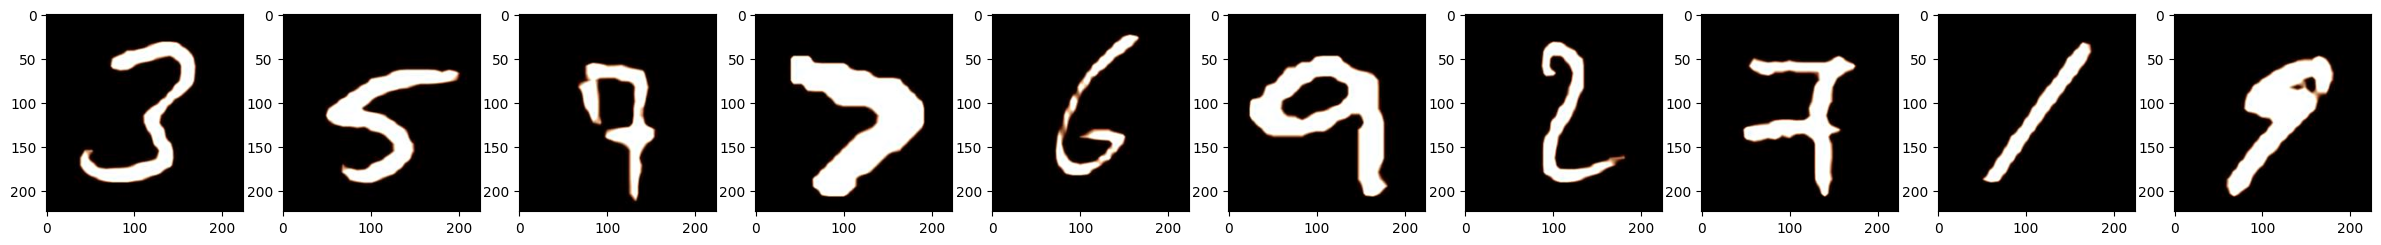

In [12]:
# set plt size
plt.rcParams["figure.figsize"] = [30, 10]

for j in range(min(10, len(image_paths))):
    plt.subplot(1, 10, j + 1)
    img = cv2.imread(image_paths[j])
    plt.imshow(img)

plt.show()

### Out-of-distribution detection

In [13]:
idx = leverage_OOD(np.array(embeddings))

In [14]:
ids_sel = np.array(ids)[idx].tolist()

In [15]:
outlier_imgs = qdrant_api.retrieve_payloads_by_ids(ids_sel, ['image_path'])
outlier_imgs = [x['image_path'] for x in outlier_imgs]

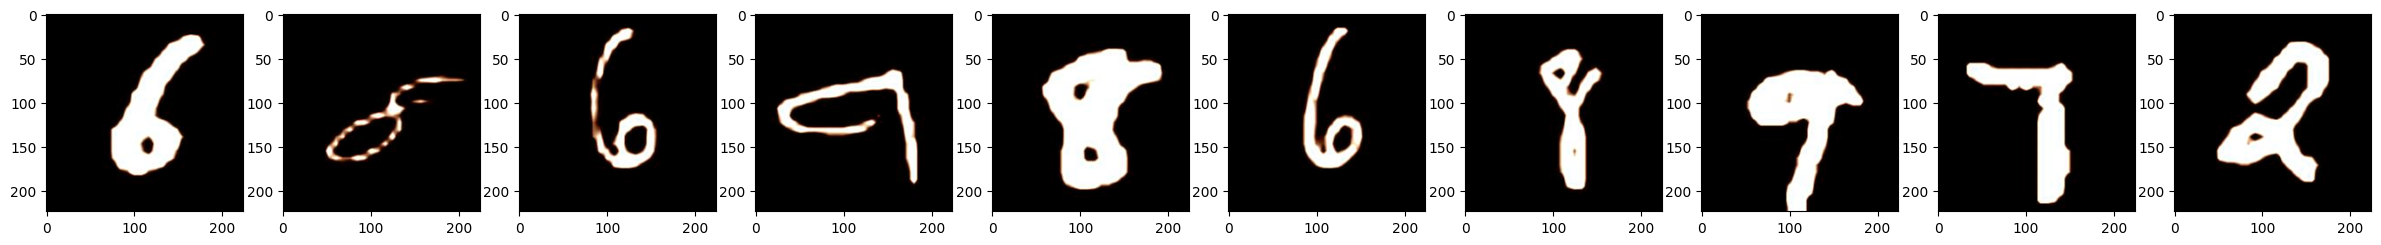

In [16]:
plt.rcParams["figure.figsize"] = [30, 10]

for j in range(min(10, len(outlier_imgs))):
    plt.subplot(1, 10, j + 1)
    img = cv2.imread(outlier_imgs[j])
    plt.imshow(img)

plt.show()

### Find similar images

/home/drew99/Luxonis-work/workspace/lux-ml/lib/python3.10/site-packages/scipy/optimize/_zeros_py.py:809: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  r = _zeros._brentq(f, a, b, xtol, rtol, maxiter, args, full_output, disp)


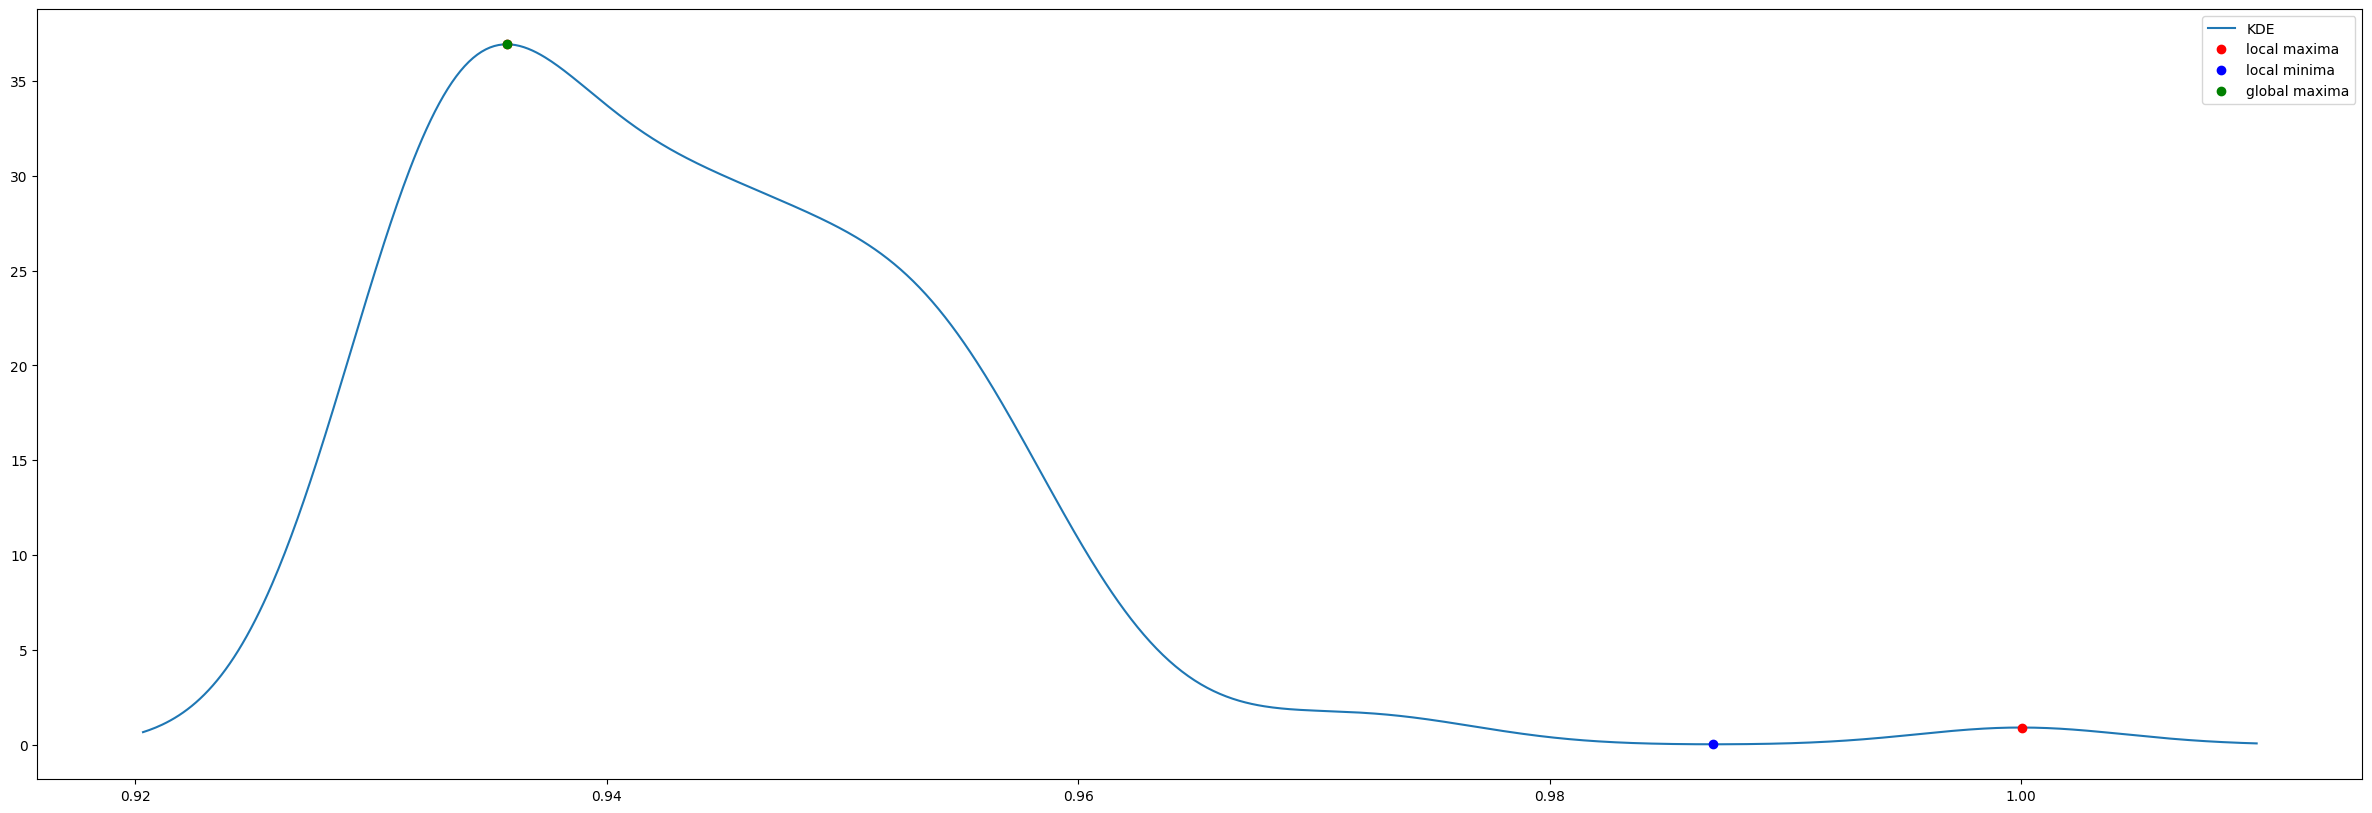

2 0.9869319475475475


In [17]:
i_sim = find_similar(
    ids[15],
    qdrant_api,
    k=100,
    n=100,
    method="first",
    k_method="kde_peaks",
    kde_bw="scott",
    plot=True,
)

In [18]:
path_sim = qdrant_api.retrieve_payloads_by_ids(i_sim, ['image_path'])
path_sim = [x['image_path'] for x in path_sim]

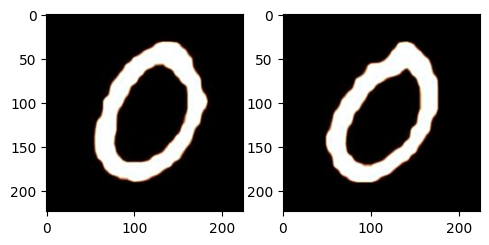

In [19]:
plt.rcParams["figure.figsize"] = [30, 10]

for j in range(min(10, len(path_sim))):
    plt.subplot(1, 10, j + 1)
    img = cv2.imread(path_sim[j])
    plt.imshow(img)

plt.show()

### Find mismatches

In [20]:
ids, embeddings = qdrant_api.retrieve_all_embeddings()
labels = qdrant_api.retrieve_payloads_by_ids(ids, ['label'])
labels = [x['label'] for x in labels]

In [21]:
X = np.array(embeddings)
y = np.array(labels)

In [22]:
mis_ix, new_y = find_mismatches_centroids(X, y)

In [23]:
missing_img_uuids = np.array(ids)[mis_ix].tolist()

In [24]:
mis_img_paths = qdrant_api.retrieve_payloads_by_ids(missing_img_uuids, ['image_path'])
mis_img_paths = [x['image_path'] for x in mis_img_paths]

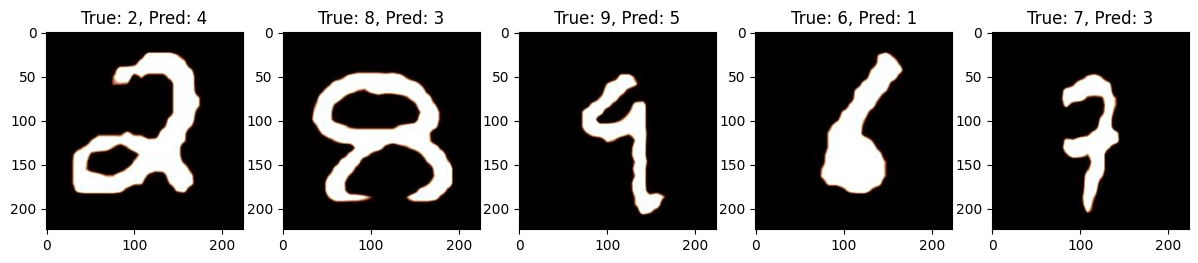

In [25]:
# plot
plt.rcParams["figure.figsize"] = [30, 10]

for j in range(min(5, len(mis_img_paths))):
    plt.subplot(1, 10, j + 1)
    img = cv2.imread(mis_img_paths[j])
    plt.title(f"True: {y[mis_ix[j]]}, Pred: {new_y[j]}")
    plt.imshow(img)

plt.show()

## Embedding processing methods using Weaviate

In [26]:
w_api = WeaviateAPI("http://localhost:8080")
w_api.create_collection("Mnist_LDF", ['label','image_path'])

Collection Mnist_LDF already exists.


In [27]:
ids, embeddings = w_api.retrieve_all_embeddings()
labels = w_api.retrieve_payloads_by_ids(ids, ['label'])
labels = [x['label'] for x in labels]

In [28]:
X = np.array(embeddings)
y = np.array(labels)

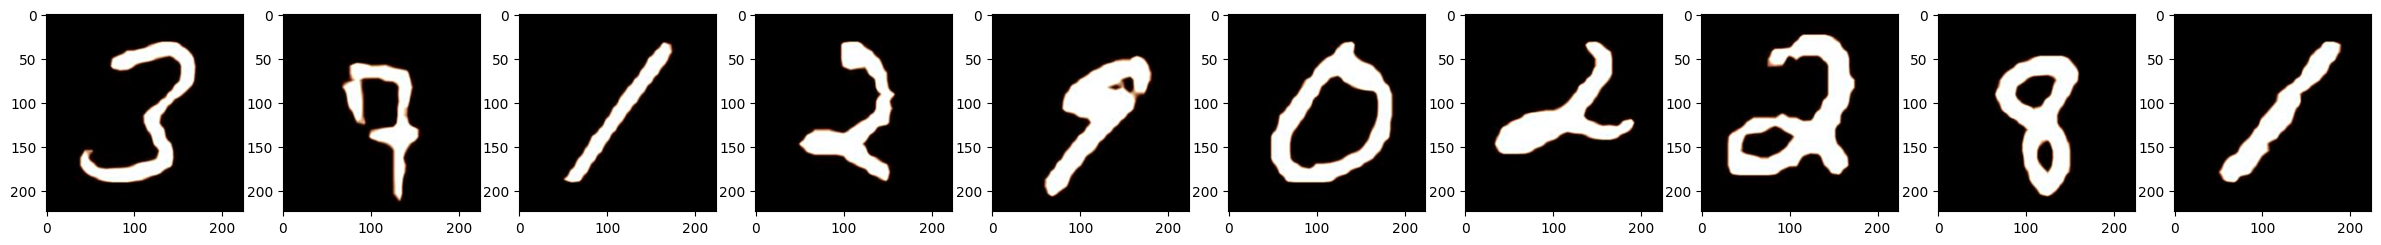

In [29]:
# find representative images
desired_size = int(len(embeddings) * 0.05)
similarity_matrix = calculate_similarity_matrix(embeddings)
selected_image_indices = find_representative_kmedoids(similarity_matrix, desired_size)

selcted_ids = np.array(ids)[selected_image_indices].tolist()
represent_img_paths = w_api.retrieve_payloads_by_ids(selcted_ids, ['image_path'])
represent_img_paths = [x['image_path'] for x in represent_img_paths]

# plot
plt.rcParams["figure.figsize"] = [30, 10]

for j in range(min(10, len(represent_img_paths))):
    plt.subplot(1, 10, j + 1)
    img = cv2.imread(represent_img_paths[j])
    plt.imshow(img)

plt.show()

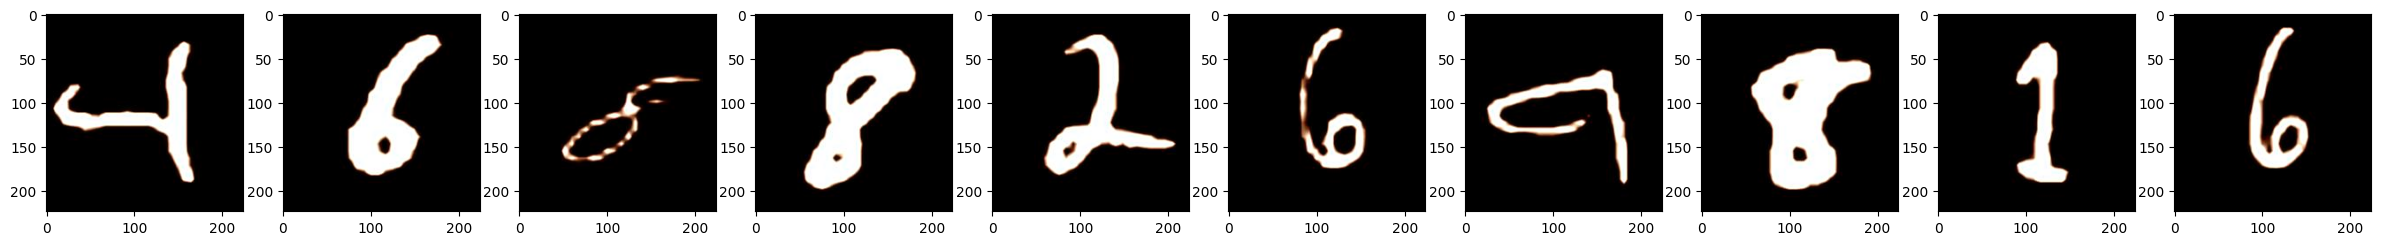

In [30]:
# find outlier images
idx = leverage_OOD(X)

out_ids = np.array(ids)[idx].tolist()
outlier_img_paths = w_api.retrieve_payloads_by_ids(out_ids, ['image_path'])
outlier_img_paths = [x['image_path'] for x in outlier_img_paths]

# plot
plt.rcParams["figure.figsize"] = [30, 10]

for j in range(min(10, len(outlier_img_paths))):
    plt.subplot(1, 10, j + 1)
    img = cv2.imread(outlier_img_paths[j])
    plt.imshow(img)

plt.show()

/home/drew99/Luxonis-work/workspace/lux-ml/lib/python3.10/site-packages/scipy/optimize/_zeros_py.py:809: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  r = _zeros._brentq(f, a, b, xtol, rtol, maxiter, args, full_output, disp)


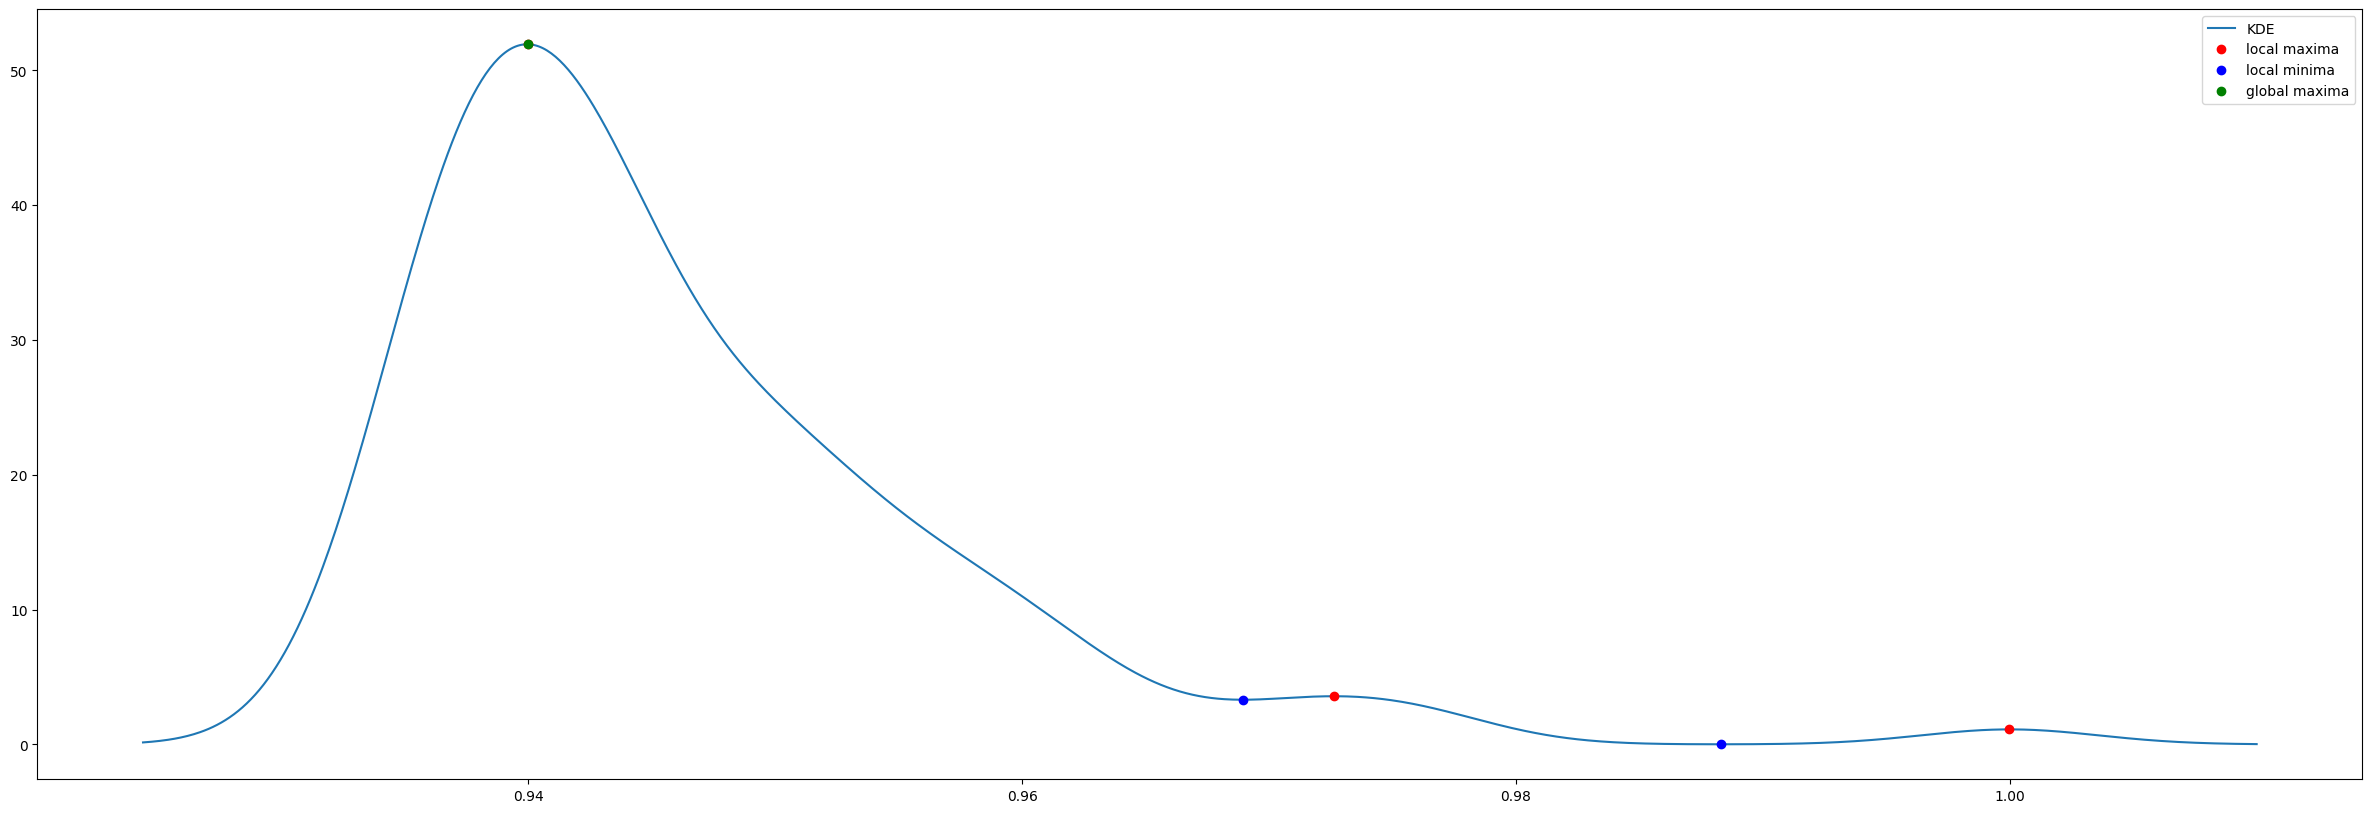

5 0.9883199661033408


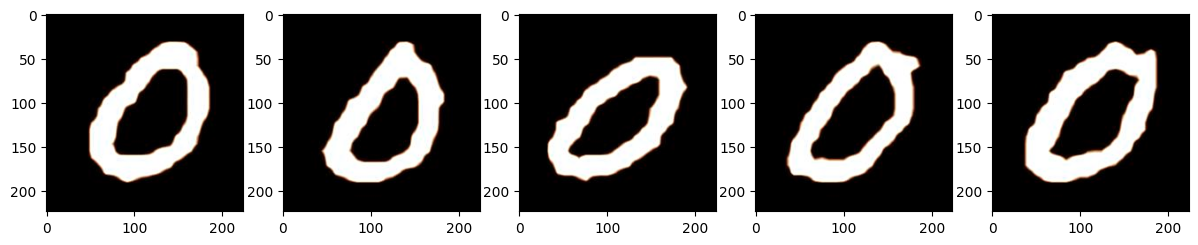

In [31]:
ids_str = [str(i) for i in ids]

# find similar/duplicate images
i_sim = find_similar(
    ids_str[4],
    w_api,
    k=100,
    n=100,
    method="first",
    k_method="kde_peaks",
    kde_bw="scott",
    plot=True,
)

sim_img_paths = w_api.retrieve_payloads_by_ids(i_sim, ['image_path'])
sim_img_paths = [x['image_path'] for x in sim_img_paths]

# plot
plt.rcParams["figure.figsize"] = [30, 10]

for j in range(min(10, len(sim_img_paths))):
    plt.subplot(1, 10, j + 1)
    img = cv2.imread(sim_img_paths[j])
    plt.imshow(img)

plt.show()

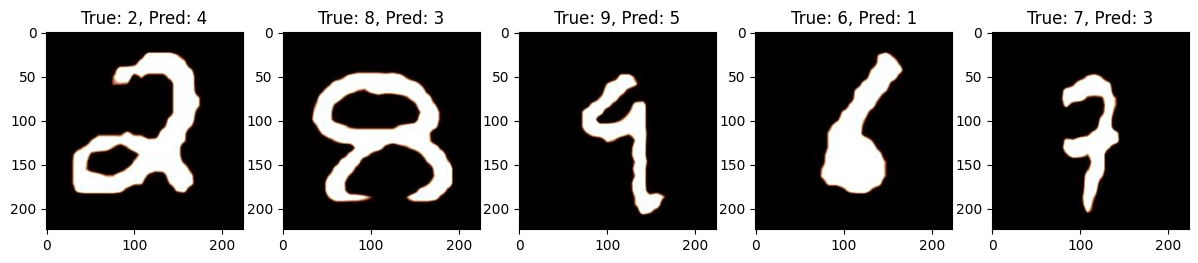

In [32]:
# find misclassified images
mis_ix, new_y = find_mismatches_centroids(X, y)

missing_img_uuids = np.array(ids)[mis_ix].tolist()
mis_img_paths = w_api.retrieve_payloads_by_ids(missing_img_uuids, ['image_path'])
mis_img_paths = [x['image_path'] for x in mis_img_paths]

# plot
plt.rcParams["figure.figsize"] = [30, 10]

for j in range(min(5, len(mis_img_paths))):
    plt.subplot(1, 10, j + 1)
    img = cv2.imread(mis_img_paths[j])
    plt.title(f"True: {y[mis_ix[j]]}, Pred: {new_y[j]}")
    plt.imshow(img)

plt.show()

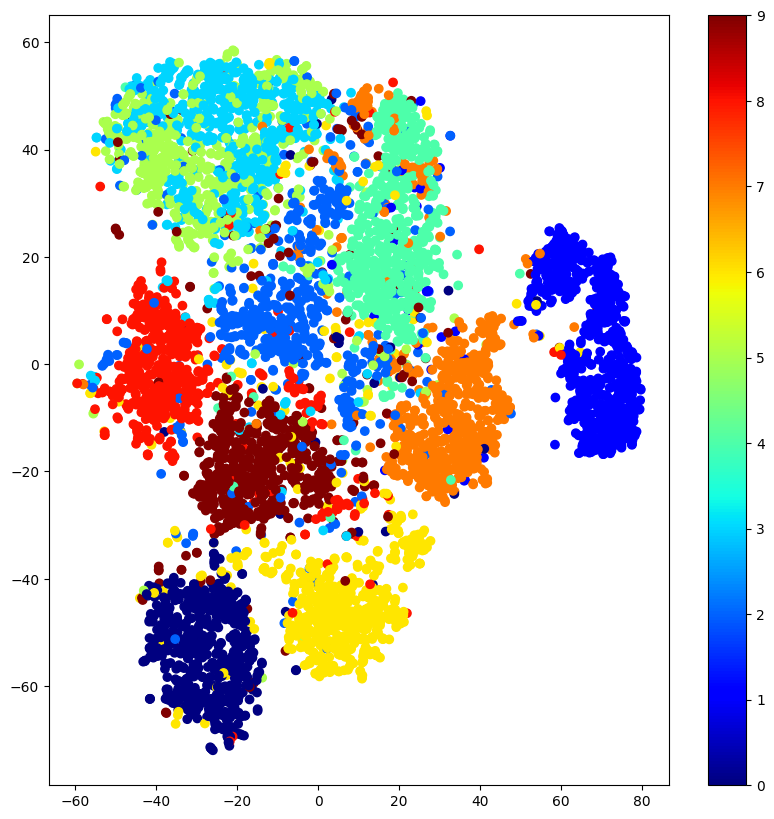

In [33]:
# plot t-sne
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(X)

plt.rcParams["figure.figsize"] = [10, 10]
y_color = [int(i) for i in y]
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_color, cmap="jet")
plt.colorbar()
plt.show()